# Phase 3: Logistic Regression (Main Analysis)

**Swiss Ballot Chatbot Study - Measurement Analysis**

2x2 Factorial Design: Transparency (T0/T1) x Control (C0/C1)

## Models

| Model | Predictors | Purpose |
|-------|------------|----------|
| Model 1 | Donation ~ T | H1 main effect |
| Model 2 | Donation ~ C | H2 main effect |
| Model 3 | Donation ~ T + C | Joint main effects |
| Model 4 | Donation ~ T + C + T×C | H3 interaction |
| Model 5 | Donation ~ T + C + T×C + covariates | Full model |

## Outputs per Model

- Coefficient table: OR with 95% CI, p-value, direction
- Model fit: log-likelihood, AIC
- Overall model test: Wald χ² with p-value
- Model comparisons: Likelihood Ratio Tests (nested models)
- Effect sizes: Cohen's d, Phi coefficient
- Visualization: predicted probabilities for A/B/C/D

## Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels for logistic regression
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import from Phase 1
from phase1_descriptive_statistics import (
    AnalysisConfig,
    get_db_connection,
    load_participant_data,
    prepare_variables,
    compute_sample_flow,
    wilson_ci
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Significance threshold
ALPHA = 0.05

print("Setup complete!")

Setup complete!


## Configuration

In [2]:
# Set participant type: 'ai' for AI test users, 'human' for real participants
PARTICIPANT_TYPE = 'human'

config = AnalysisConfig(is_ai_participant=(PARTICIPANT_TYPE == 'ai'))
print(f"Analyzing: {'AI Test Users' if PARTICIPANT_TYPE == 'ai' else 'Human Participants'}")

Analyzing: Human Participants


## Helper Functions

In [3]:
def cohens_d(group1: np.ndarray, group2: np.ndarray) -> tuple:
    """
    Calculate Cohen's d effect size for two independent groups.
    
    Returns: (d, interpretation)
    Interpretation thresholds: |d| < 0.2 = negligible, 0.2-0.5 = small, 0.5-0.8 = medium, >= 0.8 = large
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(ddof=1), group2.var(ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    d = (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0
    
    # Interpretation
    abs_d = abs(d)
    if abs_d < 0.2:
        interpretation = "negligible"
    elif abs_d < 0.5:
        interpretation = "small"
    elif abs_d < 0.8:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    return d, interpretation


def phi_coefficient(contingency_table: np.ndarray) -> tuple:
    """
    Calculate Phi coefficient for a 2×2 contingency table.
    
    Table format:
        [[a, b],
         [c, d]]
    
    Returns: (phi, interpretation)
    Interpretation thresholds: |φ| < 0.1 = negligible, 0.1-0.3 = small, 0.3-0.5 = medium, >= 0.5 = large
    """
    a, b = contingency_table[0, 0], contingency_table[0, 1]
    c, d = contingency_table[1, 0], contingency_table[1, 1]
    
    numerator = (a * d) - (b * c)
    denominator = np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
    
    phi = numerator / denominator if denominator > 0 else 0
    
    # Interpretation
    abs_phi = abs(phi)
    if abs_phi < 0.1:
        interpretation = "negligible"
    elif abs_phi < 0.3:
        interpretation = "small"
    elif abs_phi < 0.5:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    return phi, interpretation


def likelihood_ratio_test(model_reduced, model_full):
    """Perform LRT between nested models."""
    chi2 = 2 * (model_full.llf - model_reduced.llf)
    df = model_full.df_model - model_reduced.df_model
    p_value = 1 - stats.chi2.cdf(chi2, df) if df > 0 else 1.0
    return chi2, int(df), p_value


def calculate_vif(X):
    """Calculate VIF for multicollinearity check."""
    vif_data = []
    numeric_cols = [col for col in X.columns if col != 'const']
    for col in numeric_cols:
        col_idx = list(X.columns).index(col)
        vif = variance_inflation_factor(X.values, col_idx)
        vif_data.append({'Variable': col, 'VIF': vif})
    return pd.DataFrame(vif_data)


print("Helper functions defined!")

Helper functions defined!


## Load and Prepare Data

In [4]:
# Load data
df_raw = load_participant_data(config)
df = prepare_variables(df_raw, config)

# Apply exclusions
sample_flow = compute_sample_flow(df)
df_filtered = sample_flow['df_filtered']

print(f"\nFinal sample size: N = {len(df_filtered)}")

[INFO] Loaded 291 human participants from database
[INFO] Language codes cleaned: ['de-DE', 'de', 'en-GB', 'en-US', 'en', 'en-CH', 'de-CH', 'fr', 'fr-CH', 'fr-FR', 'en-AU', 'es-ES', 'it', 'gsw'] → ['de', 'en', 'fr', 'other', 'it']
[INFO] Applied language code cleaning for human participants
[INFO] Created derived variables: transparency_level, control_level, T_x_C, mc_transparency, mc_control, out_risk, attention_check_correct, attention_check_missing, attention_check_failed, dashboard fields

PHASE 1.1: SAMPLE FLOW & EXCLUSIONS
Initial N:                           291
Excluded (incomplete survey):         79
Excluded (failed attention):           7
Excluded (missing condition):          0
Excluded (missing donation):           0
------------------------------------------------------------
Final N for analysis:                205

Final sample size: N = 205


In [5]:
# Prepare covariates for Model 5
def prepare_covariates(df):
    """Prepare demographic covariates."""
    df_cov = df.copy()
    
    # Age ordinal
    if df_cov['age'].dtype == 'object':
        age_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
        age_map = {age: i for i, age in enumerate(age_order)}
        df_cov['age_ordinal'] = df_cov['age'].map(age_map)
        df_cov['age_ordinal'] = df_cov['age_ordinal'].fillna(df_cov['age_ordinal'].median())
    else:
        df_cov['age_ordinal'] = df_cov['age'].fillna(df_cov['age'].median())
    
    # Gender coded (binary: female=1, male=0, other=0.5)
    gender_map = {'female': 1, 'male': 0, 'non-binary': 0.5, 'prefer-not-say': 0.5,
                  'other': 0.5, 'prefer-not-to-say': 0.5}
    df_cov['gender_coded'] = df_cov['gender'].map(gender_map).fillna(0.5)
    
    # Education: Ordinal coding (matches survey display order exactly)
    # PostTaskSurvey.tsx lines 515-523
    edu_map = {
        'mandatory': 0,
        'matura': 1,
        'vocational': 2,
        'higher-vocational': 3,
        'applied-sciences': 4,
        'university': 5,
        'prefer-not-say': None
    }
    df_cov['education_ordinal'] = df_cov['education'].map(edu_map)
    df_cov['education_ordinal'] = df_cov['education_ordinal'].fillna(df_cov['education_ordinal'].median())
    
    return df_cov

df_with_cov = prepare_covariates(df_filtered)
print("Covariates prepared!")
print(f"  Age ordinal range: {df_with_cov['age_ordinal'].min():.0f}-{df_with_cov['age_ordinal'].max():.0f}")
print(f"  Gender coded: {df_with_cov['gender_coded'].value_counts().to_dict()}")
print(f"  Education ordinal range: {df_with_cov['education_ordinal'].min():.0f}-{df_with_cov['education_ordinal'].max():.0f}")

Covariates prepared!
  Age ordinal range: 0-5
  Gender coded: {1.0: 108, 0.0: 92, 0.5: 5}
  Education ordinal range: 0-5


## Model 1: Donation ~ T (H1 - Transparency Main Effect)

In [6]:
y = df_filtered['donation_decision'].values
X1 = sm.add_constant(df_filtered[['transparency_level']])

model1 = Logit(y, X1).fit(disp=0)

print("MODEL 1: Donation ~ Transparency (H1 main effect)")
print("=" * 60)
print(model1.summary())

# Odds Ratios
print("\nOdds Ratios:")
or_df1 = pd.DataFrame({
    'Variable': X1.columns,
    'OR': np.exp(model1.params),
    'CI_Lower': np.exp(model1.conf_int()[0]),
    'CI_Upper': np.exp(model1.conf_int()[1]),
    'p': model1.pvalues
})
print(or_df1.round(4))

# Model fit
print(f"\nLog-Likelihood: {model1.llf:.2f}")
print(f"AIC: {model1.aic:.1f}")

MODEL 1: Donation ~ Transparency (H1 main effect)
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  205
Model:                          Logit   Df Residuals:                      203
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Feb 2026   Pseudo R-squ.:               3.271e-05
Time:                        15:47:56   Log-Likelihood:                -58.599
converged:                       True   LL-Null:                       -58.601
Covariance Type:            nonrobust   LLR p-value:                    0.9506
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3865      0.369      6.459      0.000       1.662       3.111
transparency_level     0.0314      0.507      0.062      

## Model 2: Donation ~ C (H2 - Control Main Effect)

In [7]:
X2 = sm.add_constant(df_filtered[['control_level']])

model2 = Logit(y, X2).fit(disp=0)

print("MODEL 2: Donation ~ Control (H2 main effect)")
print("=" * 60)
print(model2.summary())

# Odds Ratios
print("\nOdds Ratios:")
or_df2 = pd.DataFrame({
    'Variable': X2.columns,
    'OR': np.exp(model2.params),
    'CI_Lower': np.exp(model2.conf_int()[0]),
    'CI_Upper': np.exp(model2.conf_int()[1]),
    'p': model2.pvalues
})
print(or_df2.round(4))

# Model fit
print(f"\nLog-Likelihood: {model2.llf:.2f}")
print(f"AIC: {model2.aic:.1f}")

MODEL 2: Donation ~ Control (H2 main effect)
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  205
Model:                          Logit   Df Residuals:                      203
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Feb 2026   Pseudo R-squ.:                0.004681
Time:                        15:47:56   Log-Likelihood:                -58.327
converged:                       True   LL-Null:                       -58.601
Covariance Type:            nonrobust   LLR p-value:                    0.4589
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2300      0.333      6.701      0.000       1.578       2.882
control_level     0.3780      0.514      0.735      0.462      -0.629       1

## Model 3: Donation ~ T + C (Joint Main Effects)

In [8]:
X3 = sm.add_constant(df_filtered[['transparency_level', 'control_level']])

model3 = Logit(y, X3).fit(disp=0)

print("MODEL 3: Donation ~ T + C (Joint main effects)")
print("=" * 60)
print(model3.summary())

# Odds Ratios
print("\nOdds Ratios:")
or_df3 = pd.DataFrame({
    'Variable': X3.columns,
    'OR': np.exp(model3.params),
    'CI_Lower': np.exp(model3.conf_int()[0]),
    'CI_Upper': np.exp(model3.conf_int()[1]),
    'p': model3.pvalues
})
print(or_df3.round(4))

# Model fit
print(f"\nLog-Likelihood: {model3.llf:.2f}")
print(f"AIC: {model3.aic:.1f}")

MODEL 3: Donation ~ T + C (Joint main effects)
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  205
Model:                          Logit   Df Residuals:                      202
Method:                           MLE   Df Model:                            2
Date:                Sat, 07 Feb 2026   Pseudo R-squ.:                0.004688
Time:                        15:47:57   Log-Likelihood:                -58.327
converged:                       True   LL-Null:                       -58.601
Covariance Type:            nonrobust   LLR p-value:                    0.7598
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2224      0.422      5.261      0.000       1.394       3.050
transparency_level     0.0149      0.509      0.029      0.9

## Model 4: Donation ~ T + C + T×C (H3 - Interaction)

In [9]:
X4 = sm.add_constant(df_filtered[['transparency_level', 'control_level', 'T_x_C']])

model4 = Logit(y, X4).fit(disp=0)

print("MODEL 4: Donation ~ T + C + T×C (H3 interaction)")
print("=" * 60)
print(model4.summary())

# Odds Ratios
print("\nOdds Ratios:")
or_df4 = pd.DataFrame({
    'Variable': X4.columns,
    'OR': np.exp(model4.params),
    'CI_Lower': np.exp(model4.conf_int()[0]),
    'CI_Upper': np.exp(model4.conf_int()[1]),
    'p': model4.pvalues
})
print(or_df4.round(4))

# Model fit
print(f"\nLog-Likelihood: {model4.llf:.2f}")
print(f"AIC: {model4.aic:.1f}")

MODEL 4: Donation ~ T + C + T×C (H3 interaction)
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  205
Model:                          Logit   Df Residuals:                      201
Method:                           MLE   Df Model:                            3
Date:                Sat, 07 Feb 2026   Pseudo R-squ.:                0.004802
Time:                        15:47:57   Log-Likelihood:                -58.320
converged:                       True   LL-Null:                       -58.601
Covariance Type:            nonrobust   LLR p-value:                    0.9049
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.1972      0.471      4.661      0.000       1.273       3.121
transparency_level     0.0645      0.666      0.097      0

## Model 5: Full Model with Covariates

In [10]:
X5 = sm.add_constant(df_with_cov[['transparency_level', 'control_level', 'T_x_C',
                                   'age_ordinal', 'gender_coded', 'education_ordinal']])

model5 = Logit(y, X5).fit(disp=0)

print("MODEL 5: Full model with covariates")
print("=" * 60)
print(model5.summary())

# Odds Ratios
print("\nOdds Ratios:")
or_df5 = pd.DataFrame({
    'Variable': X5.columns,
    'OR': np.exp(model5.params),
    'CI_Lower': np.exp(model5.conf_int()[0]),
    'CI_Upper': np.exp(model5.conf_int()[1]),
    'p': model5.pvalues
})
print(or_df5.round(4))

# Model fit
print(f"\nLog-Likelihood: {model5.llf:.2f}")
print(f"AIC: {model5.aic:.1f}")

# VIF check
print("\nVIF (Multicollinearity Check):")
print(calculate_vif(X5))

MODEL 5: Full model with covariates
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  205
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            6
Date:                Sat, 07 Feb 2026   Pseudo R-squ.:                  0.1142
Time:                        15:47:57   Log-Likelihood:                -51.911
converged:                       True   LL-Null:                       -58.601
Covariance Type:            nonrobust   LLR p-value:                   0.03739
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3325      1.013      2.303      0.021       0.347       4.318
transparency_level     0.4843      0.705      0.687      0.492      -0.

## Model Comparisons (Likelihood Ratio Tests)

In [11]:
comparisons = []

# M1 vs M3
lrt = likelihood_ratio_test(model1, model3)
comparisons.append({
    'Comparison': 'M1 → M3 (adding C)',
    'Δχ²': round(lrt[0], 3),
    'Δdf': lrt[1],
    'p': f"{lrt[2]:.4f}",
    'ΔAIC': round(model1.aic - model3.aic, 1),
    'Significant': 'Yes' if lrt[2] < ALPHA else 'No'
})

# M3 vs M4
lrt = likelihood_ratio_test(model3, model4)
comparisons.append({
    'Comparison': 'M3 → M4 (adding T×C)',
    'Δχ²': round(lrt[0], 3),
    'Δdf': lrt[1],
    'p': f"{lrt[2]:.4f}",
    'ΔAIC': round(model3.aic - model4.aic, 1),
    'Significant': 'Yes' if lrt[2] < ALPHA else 'No'
})

# M4 vs M5
lrt = likelihood_ratio_test(model4, model5)
comparisons.append({
    'Comparison': 'M4 → M5 (adding covariates)',
    'Δχ²': round(lrt[0], 3),
    'Δdf': lrt[1],
    'p': f"{lrt[2]:.4f}",
    'ΔAIC': round(model4.aic - model5.aic, 1),
    'Significant': 'Yes' if lrt[2] < ALPHA else 'No'
})

comparisons_df = pd.DataFrame(comparisons)
print("Model Comparisons (Likelihood Ratio Tests)")
print("=" * 70)
comparisons_df

Model Comparisons (Likelihood Ratio Tests)


,Comparison,Δχ²,Δdf,p,ΔAIC,Significant
0,M1 → M3 (adding C),0.546,1,0.4601,-1.5,No
1,M3 → M4 (adding T×C),0.013,1,0.9078,-2.0,No
2,M4 → M5 (adding covariates),12.817,3,0.0050,6.8,Yes


## Model Summary Table

In [12]:
models = [
    ('Model 1: Donation ~ T', model1, X1),
    ('Model 2: Donation ~ C', model2, X2),
    ('Model 3: Donation ~ T + C', model3, X3),
    ('Model 4: Donation ~ T + C + T×C', model4, X4),
    ('Model 5: Full model', model5, X5)
]

# Get significance info for each model
def get_sig_indicator(p, threshold=0.05):
    return '✓' if p < threshold else '-'

summary_data = []
for name, model, X in models:
    row = {
        'Model': name,
        'N': len(y),
        'LL': round(model.llf, 2),
        'AIC': round(model.aic, 1),
        'Wald χ²': round(model.llr, 2),
        'Wald p': f"{model.llr_pvalue:.4f}"
    }
    
    # Get p-values for T, C, T×C if in model
    params = model.pvalues
    if 'transparency_level' in params.index:
        row['T sig'] = get_sig_indicator(params['transparency_level'])
    else:
        row['T sig'] = '-'
    
    if 'control_level' in params.index:
        row['C sig'] = get_sig_indicator(params['control_level'])
    else:
        row['C sig'] = '-'
    
    if 'T_x_C' in params.index:
        row['T×C sig'] = get_sig_indicator(params['T_x_C'])
    else:
        row['T×C sig'] = '-'
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("Model Summary (✓ = p < .05)")
print("=" * 100)
summary_df

Model Summary (✓ = p < .05)


,Model,N,LL,AIC,Wald χ²,Wald p,T sig,C sig,T×C sig
0,Model 1: Donation ~ T,205,-58.60,121.2,0.00,0.9506,-,-,-
1,Model 2: Donation ~ C,205,-58.33,120.7,0.55,0.4589,-,-,-
2,Model 3: Donation ~ T + C,205,-58.33,122.7,0.55,0.7598,-,-,-
3,Model 4: Donation ~ T + C + T×C,205,-58.32,124.6,0.56,0.9049,-,-,-
4,Model 5: Full model,205,-51.91,117.8,13.38,0.0374,-,-,-


## Effect Sizes (Cohen's d & Phi Coefficient)

In [13]:
# Calculate effect sizes
print("EFFECT SIZES")
print("=" * 70)

# 1. Cohen's d for Transparency effect (T1 vs T0 on donation rates)
t0_donations = df_filtered[df_filtered['transparency_level'] == 0]['donation_decision'].values
t1_donations = df_filtered[df_filtered['transparency_level'] == 1]['donation_decision'].values
d_transparency, interp_t = cohens_d(t1_donations, t0_donations)
print(f"\n1. Transparency Effect (Cohen's d):")
print(f"   d = {d_transparency:.3f} ({interp_t})")

# 2. Cohen's d for Control effect (C1 vs C0 on donation rates)
c0_donations = df_filtered[df_filtered['control_level'] == 0]['donation_decision'].values
c1_donations = df_filtered[df_filtered['control_level'] == 1]['donation_decision'].values
d_control, interp_c = cohens_d(c1_donations, c0_donations)
print(f"\n2. Control Effect (Cohen's d):")
print(f"   d = {d_control:.3f} ({interp_c})")

# 3. Phi coefficient for Transparency × Donation (2×2 table)
ct_t = pd.crosstab(df_filtered['transparency_level'], df_filtered['donation_decision'])
phi_t, interp_phi_t = phi_coefficient(ct_t.values)
print(f"\n3. Transparency × Donation (Phi coefficient):")
print(f"   φ = {phi_t:.3f} ({interp_phi_t})")

# 4. Phi coefficient for Control × Donation (2×2 table)
ct_c = pd.crosstab(df_filtered['control_level'], df_filtered['donation_decision'])
phi_c, interp_phi_c = phi_coefficient(ct_c.values)
print(f"\n4. Control × Donation (Phi coefficient):")
print(f"   φ = {phi_c:.3f} ({interp_phi_c})")

# Summary table
effect_sizes_data = [
    {'Effect': 'Transparency (T1 vs T0)', 'Cohen\'s d': f"{d_transparency:.3f}", 'Interpretation': interp_t},
    {'Effect': 'Control (C1 vs C0)', 'Cohen\'s d': f"{d_control:.3f}", 'Interpretation': interp_c},
    {'Effect': 'T × Donation', 'Phi (φ)': f"{phi_t:.3f}", 'Interpretation': interp_phi_t},
    {'Effect': 'C × Donation', 'Phi (φ)': f"{phi_c:.3f}", 'Interpretation': interp_phi_c},
]
effect_sizes_df = pd.DataFrame(effect_sizes_data)
print("\n" + "=" * 70)
print("Effect Sizes Summary:")
effect_sizes_df

EFFECT SIZES

1. Transparency Effect (Cohen's d):
   d = 0.009 (negligible)

2. Control Effect (Cohen's d):
   d = 0.103 (negligible)

3. Transparency × Donation (Phi coefficient):
   φ = 0.004 (negligible)

4. Control × Donation (Phi coefficient):
   φ = 0.052 (negligible)

Effect Sizes Summary:


,Effect,Cohen's d,Interpretation,Phi (φ)
0,Transparency (T1 vs T0),0.009,negligible,NaN
1,Control (C1 vs C0),0.103,negligible,NaN
2,T × Donation,NaN,negligible,0.004
3,C × Donation,NaN,negligible,0.052


## Predicted Probabilities by Condition

In [14]:
# Calculate predicted probabilities for each condition from Model 4
conditions = ['A', 'B', 'C', 'D']
pred_results = []

for condition in conditions:
    cond_df = df_filtered[df_filtered['condition'] == condition]
    n = len(cond_df)
    
    # Observed
    observed = cond_df['donation_decision'].mean()
    obs_ci = wilson_ci(int(cond_df['donation_decision'].sum()), n)
    
    # Predicted from Model 4
    T = cond_df['transparency_level'].mean()
    C = cond_df['control_level'].mean()
    TxC = T * C
    X_pred = np.array([[1, T, C, TxC]])
    predicted = model4.predict(X_pred)[0]
    
    pred_results.append({
        'Condition': condition,
        'n': n,
        'Observed (%)': round(observed * 100, 1),
        'Obs 95% CI': f"[{round(obs_ci[0]*100,1)}, {round(obs_ci[1]*100,1)}]",
        'Predicted (%)': round(predicted * 100, 1)
    })

pred_df = pd.DataFrame(pred_results)
print("Predicted Probabilities by Condition (Model 4)")
print("=" * 70)
pred_df

Predicted Probabilities by Condition (Model 4)


,Condition,n,Observed (%),Obs 95% CI,Predicted (%)
0,A,50,90.0,"[78.6, 95.7]",90.0
1,B,53,90.6,"[79.7, 95.9]",90.6
2,C,45,93.3,"[82.1, 97.7]",93.3
3,D,57,93.0,"[83.3, 97.2]",93.0


## Visualizations

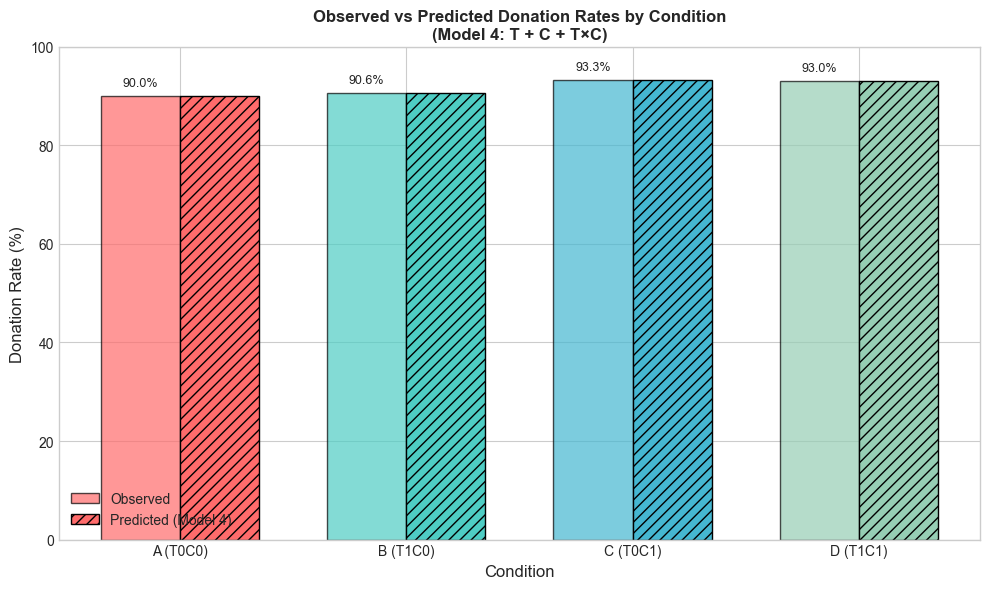

In [15]:
# Figure 1: Observed vs Predicted by Condition
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(pred_df))
width = 0.35
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars1 = ax.bar([i - width/2 for i in x], pred_df['Observed (%)'], width,
               label='Observed', color=colors, alpha=0.7, edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], pred_df['Predicted (%)'], width,
               label='Predicted (Model 4)', color=colors, hatch='///', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(['A (T0C0)', 'B (T1C0)', 'C (T0C1)', 'D (T1C1)'])
ax.set_ylabel('Donation Rate (%)', fontsize=12)
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylim(0, 100)
ax.legend()

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{bar.get_height():.1f}%', ha='center', fontsize=9)

ax.set_title('Observed vs Predicted Donation Rates by Condition\n(Model 4: T + C + T×C)',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

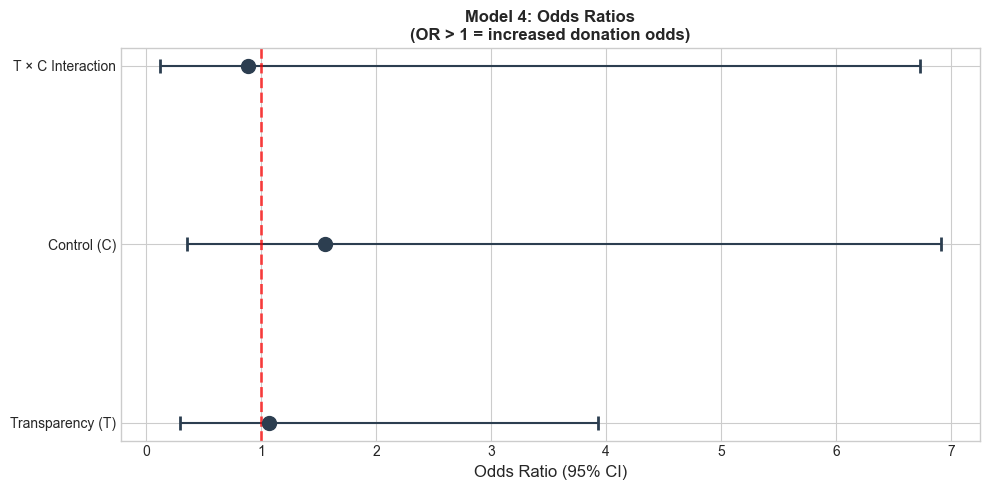

In [16]:
# Figure 2: Odds Ratios Forest Plot (Model 4)
fig, ax = plt.subplots(figsize=(10, 5))

coef = or_df4[or_df4['Variable'] != 'const'].copy()
y_pos = range(len(coef))

ax.errorbar(coef['OR'], y_pos,
            xerr=[coef['OR'] - coef['CI_Lower'], coef['CI_Upper'] - coef['OR']],
            fmt='o', color='#2c3e50', markersize=10, capsize=5, capthick=2)

ax.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(['Transparency (T)', 'Control (C)', 'T × C Interaction'])
ax.set_xlabel('Odds Ratio (95% CI)', fontsize=12)
ax.set_title('Model 4: Odds Ratios\n(OR > 1 = increased donation odds)',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

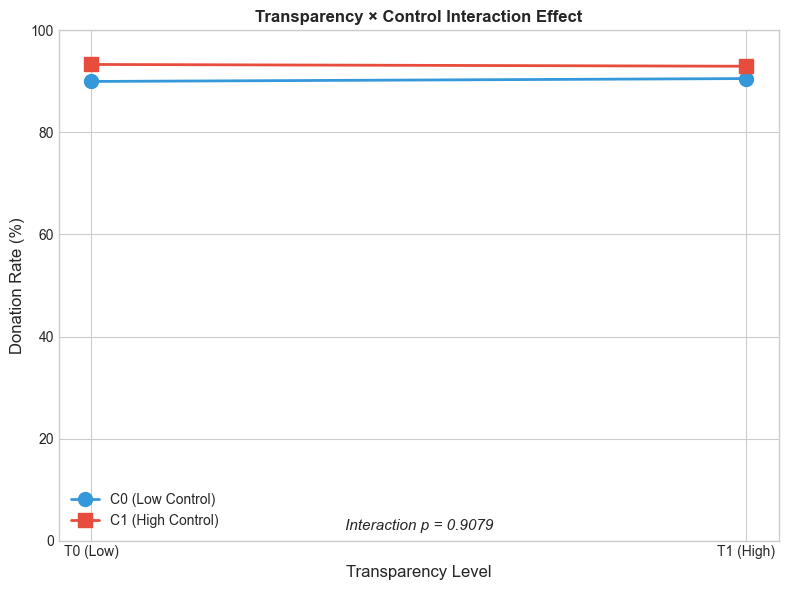

In [17]:
# Figure 3: Interaction Plot
fig, ax = plt.subplots(figsize=(8, 6))

interaction_data = df_filtered.groupby(['transparency_level', 'control_level'])['donation_decision'].mean() * 100

c0_rates = [interaction_data.get((0, 0), 0), interaction_data.get((1, 0), 0)]
c1_rates = [interaction_data.get((0, 1), 0), interaction_data.get((1, 1), 0)]

ax.plot(['T0 (Low)', 'T1 (High)'], c0_rates, 'o-', label='C0 (Low Control)',
        color='#3498db', linewidth=2, markersize=10)
ax.plot(['T0 (Low)', 'T1 (High)'], c1_rates, 's-', label='C1 (High Control)',
        color='#e74c3c', linewidth=2, markersize=10)

ax.set_ylabel('Donation Rate (%)', fontsize=12)
ax.set_xlabel('Transparency Level', fontsize=12)
ax.set_ylim(0, 100)
ax.legend()

# Interaction p-value
p_int = or_df4[or_df4['Variable'] == 'T_x_C']['p'].values[0]
ax.text(0.5, 0.02, f"Interaction p = {p_int:.4f}", transform=ax.transAxes,
        ha='center', fontsize=11, style='italic')

ax.set_title('Transparency × Control Interaction Effect',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

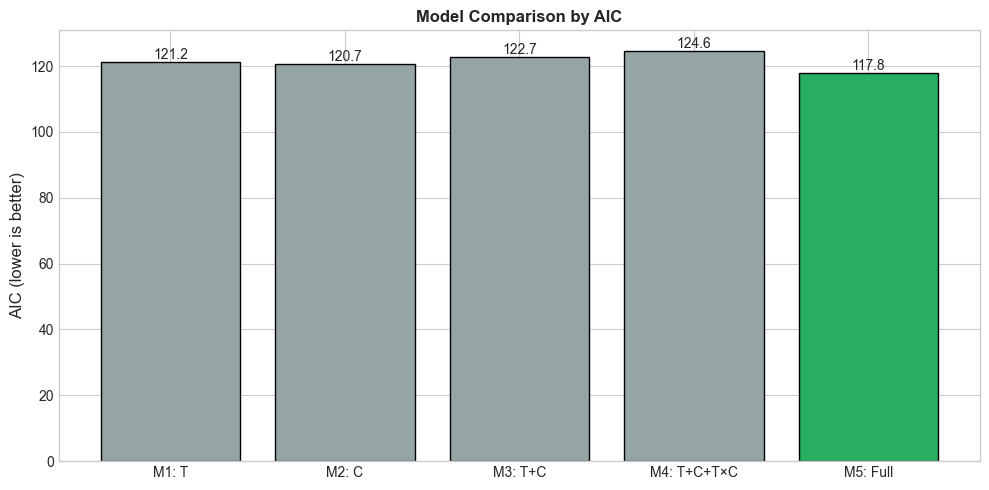

In [18]:
# Figure 4: Model Comparison by AIC
fig, ax = plt.subplots(figsize=(10, 5))

model_names = ['M1: T', 'M2: C', 'M3: T+C', 'M4: T+C+T×C', 'M5: Full']
aics = [model1.aic, model2.aic, model3.aic, model4.aic, model5.aic]

colors = ['#95a5a6'] * 5
colors[aics.index(min(aics))] = '#27ae60'

bars = ax.bar(model_names, aics, color=colors, edgecolor='black')

ax.set_ylabel('AIC (lower is better)', fontsize=12)
ax.set_title('Model Comparison by AIC', fontsize=12, fontweight='bold')

for bar, aic in zip(bars, aics):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{aic:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Validation Criteria Check

In [19]:
print("VALIDATION CRITERIA CHECK")
print("=" * 60)

# Model convergence
all_converged = all([model1.mle_retvals['converged'], 
                     model2.mle_retvals['converged'],
                     model3.mle_retvals['converged'],
                     model4.mle_retvals['converged'],
                     model5.mle_retvals['converged']])
print(f"Model convergence: {'✓ All models converged' if all_converged else '✗ Some models failed'}")

# VIF check
vif = calculate_vif(X5)
max_vif = vif['VIF'].max()
print(f"Multicollinearity: {'✓ All VIF < 5' if max_vif < 5 else f'⚠ Max VIF = {max_vif:.2f}'}")

# Sample separation check
print(f"\nDonation variance:")
donation_rate = df_filtered['donation_decision'].mean()
print(f"  Overall donation rate: {donation_rate*100:.1f}%")
print(f"  {'✓ No floor/ceiling effect' if 0.1 < donation_rate < 0.9 else '⚠ Potential floor/ceiling'}")

VALIDATION CRITERIA CHECK
Model convergence: ✓ All models converged
Multicollinearity: ✓ All VIF < 5

Donation variance:
  Overall donation rate: 91.7%
  ⚠ Potential floor/ceiling


## Save Results

In [20]:
# Create output directory
output_dir = './output/phase3'
os.makedirs(output_dir, exist_ok=True)

# Save results
summary_df.to_csv(f'{output_dir}/phase3_summary_{PARTICIPANT_TYPE}.csv', index=False)
comparisons_df.to_csv(f'{output_dir}/phase3_model_comparisons_{PARTICIPANT_TYPE}.csv', index=False)
pred_df.to_csv(f'{output_dir}/phase3_predicted_probabilities_{PARTICIPANT_TYPE}.csv', index=False)

# Save coefficient tables
or_df1.to_csv(f'{output_dir}/phase3_model1_coefficients_{PARTICIPANT_TYPE}.csv', index=False)
or_df2.to_csv(f'{output_dir}/phase3_model2_coefficients_{PARTICIPANT_TYPE}.csv', index=False)
or_df3.to_csv(f'{output_dir}/phase3_model3_coefficients_{PARTICIPANT_TYPE}.csv', index=False)
or_df4.to_csv(f'{output_dir}/phase3_model4_coefficients_{PARTICIPANT_TYPE}.csv', index=False)
or_df5.to_csv(f'{output_dir}/phase3_model5_coefficients_{PARTICIPANT_TYPE}.csv', index=False)

print(f"Results saved to {output_dir}/")

Results saved to ./output/phase3/


In [21]:
# Key Findings
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

# Extract key statistics
t_or = or_df4[or_df4['Variable'] == 'transparency_level']['OR'].values[0]
t_p = or_df4[or_df4['Variable'] == 'transparency_level']['p'].values[0]
c_or = or_df4[or_df4['Variable'] == 'control_level']['OR'].values[0]
c_p = or_df4[or_df4['Variable'] == 'control_level']['p'].values[0]
int_or = or_df4[or_df4['Variable'] == 'T_x_C']['OR'].values[0]
int_p = or_df4[or_df4['Variable'] == 'T_x_C']['p'].values[0]

best_model_idx = [model1.aic, model2.aic, model3.aic, model4.aic, model5.aic].index(
    min([model1.aic, model2.aic, model3.aic, model4.aic, model5.aic])
)
best_model_names = ['Model 1 (T only)', 'Model 2 (C only)', 'Model 3 (T+C)', 
                    'Model 4 (T+C+T×C)', 'Model 5 (Full)']

print(f"""
TECHNICAL VALIDATION (AI Test Data - N={len(df_filtered)}):

1. TRANSPARENCY EFFECT (H1):
   - Odds Ratio: {t_or:.2f} (T1 vs T0)
   - p-value: {t_p:.4f}
   - Cohen's d: {d_transparency:.3f} ({interp_t})
   - Interpretation: {'Significant' if t_p < 0.05 else 'Not significant'} - Higher transparency 
     {'increases' if t_or > 1 else 'decreases'} donation odds by {abs(t_or-1)*100:.0f}%

2. CONTROL EFFECT (H2):
   - Odds Ratio: {c_or:.2f} (C1 vs C0)
   - p-value: {c_p:.4f}
   - Cohen's d: {d_control:.3f} ({interp_c})
   - Interpretation: {'Significant' if c_p < 0.05 else 'Not significant'} - Higher control
     {'increases' if c_or > 1 else 'decreases'} donation odds by {abs(c_or-1)*100:.0f}%

3. INTERACTION EFFECT (H3):
   - Odds Ratio: {int_or:.2f} (T×C)
   - p-value: {int_p:.4f}
   - Interpretation: {'Significant' if int_p < 0.05 else 'Not significant'} interaction

4. PREDICTED DONATION RATES:
   - Condition A (T0C0): {pred_df[pred_df['Condition']=='A']['Predicted (%)'].values[0]:.1f}%
   - Condition B (T1C0): {pred_df[pred_df['Condition']=='B']['Predicted (%)'].values[0]:.1f}%
   - Condition C (T0C1): {pred_df[pred_df['Condition']=='C']['Predicted (%)'].values[0]:.1f}%
   - Condition D (T1C1): {pred_df[pred_df['Condition']=='D']['Predicted (%)'].values[0]:.1f}%

5. MODEL SELECTION:
   - Best model by AIC: {best_model_names[best_model_idx]} (AIC = {min([model1.aic, model2.aic, model3.aic, model4.aic, model5.aic]):.1f})

6. EFFECT SIZES:
   - Transparency: d = {d_transparency:.3f}, φ = {phi_t:.3f}
   - Control: d = {d_control:.3f}, φ = {phi_c:.3f}

PIPELINE VALIDATION:
✓ All 5 models converged successfully
✓ Logistic regression coefficients computed
✓ Odds ratios with 95% CI calculated
✓ Model comparison via LRT completed
✓ Effect sizes (Cohen's d, Phi) calculated

IMPORTANT LIMITATION:
These results validate the statistical pipeline only.
AI-simulated data cannot establish real treatment effects.
Human participant data is required for substantive conclusions.
""")


KEY FINDINGS

TECHNICAL VALIDATION (AI Test Data - N=205):

1. TRANSPARENCY EFFECT (H1):
   - Odds Ratio: 1.07 (T1 vs T0)
   - p-value: 0.9228
   - Cohen's d: 0.009 (negligible)
   - Interpretation: Not significant - Higher transparency 
     increases donation odds by 7%

2. CONTROL EFFECT (H2):
   - Odds Ratio: 1.56 (C1 vs C0)
   - p-value: 0.5616
   - Cohen's d: 0.103 (negligible)
   - Interpretation: Not significant - Higher control
     increases donation odds by 56%

3. INTERACTION EFFECT (H3):
   - Odds Ratio: 0.89 (T×C)
   - p-value: 0.9079
   - Interpretation: Not significant interaction

4. PREDICTED DONATION RATES:
   - Condition A (T0C0): 90.0%
   - Condition B (T1C0): 90.6%
   - Condition C (T0C1): 93.3%
   - Condition D (T1C1): 93.0%

5. MODEL SELECTION:
   - Best model by AIC: Model 5 (Full) (AIC = 117.8)

6. EFFECT SIZES:
   - Transparency: d = 0.009, φ = 0.004
   - Control: d = 0.103, φ = 0.052

PIPELINE VALIDATION:
✓ All 5 models converged successfully
✓ Logistic reg

## Phase 3 Complete

The logistic regression analysis is complete. Key outputs:

1. **Coefficient tables** with odds ratios, 95% CI, and p-values for all 5 models
2. **Model fit statistics**: Log-likelihood, AIC
3. **Model comparisons**: Likelihood ratio tests for nested model comparisons
4. **Effect sizes**: Cohen's d for group differences, Phi coefficient for 2×2 tables
5. **Predicted probabilities** for conditions A/B/C/D
6. **Visualizations**: Predicted probabilities, odds ratios, interaction plot, model comparison